In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

warnings.filterwarnings('ignore')

mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = 'NanumGothic'

In [2]:
import requests
import json
import re
from json import loads
import datetime
import time
import pickle
import random

## 1. 불러오기

### 1-1. 동대문구 내 따릉이 대여소 ID

In [7]:
with open('./bike_stop_data/Bike_Stop_ID.pickle', 'rb') as fr:
    Bike_Stop_ID = pickle.load(fr)
    
Bike_Stop_ID

array([600, 601, 602, 604, 605, 606, 607, 608, 609, 610, 612, 613, 614,
       615, 616, 617, 621, 622, 623, 624, 625, 626, 627, 628, 630, 631,
       633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 646, 647,
       648, 650, 651, 652, 654, 656, 657, 658, 659, 660, 661, 663],
      dtype=int64)

### 1-2. 동대문구 내 따릉이 대여소 위치 (경도, 위도)

In [9]:
with open('./bike_stop_data/Bike_Stop_POS.pickle', 'rb') as fr:
    Bike_Stop_POS = pickle.load(fr)
    
##Bike_Stop_POS

### 1-3. 동대문구 내 따릉이 대여소 간 자동차로 걸리는 시간

In [10]:
with open('./bike_stop_data/Bike_Stop_Time.pickle', 'rb') as fr:
    Bike_Stop_Time = pickle.load(fr)

In [11]:
time1 = {}
for k, l in zip(Bike_Stop_ID, range(51)):
    t = list(Bike_Stop_Time[str(k)].values())
    del t[l]
    t = np.array(t)
    time1[str(k)] = np.mean(t)

In [15]:
time2 = []
for k in time1.values():
    time2 += [k]
    
avg_time = np.mean(np.array(time2))
print("avg sec: " + str(avg_time))
print("avg hhmmss: " + str(datetime.timedelta(0, avg_time)))

avg sec: 836.9686274509804
avg hhmmss: 0:13:56.968627


## 2. 다음날(201128)의 유입정도 예측

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model as lm
import xgboost as xgb
from scipy.stats import uniform, randint
#import pickle
import os

In [18]:
dayofweek = ["요일_"+str(i) for i in range(7)]
features = ['월', '시간', '최저기온(°C)', '최고기온(°C)', '일강수량(mm)', '최대 풍속(m/s)', '평균 상대습도(%)'] + dayofweek
cols = ['월', '요일', '시간', '최저기온(°C)', '최고기온(°C)', '일강수량(mm)', '최대 풍속(m/s)', '평균 상대습도(%)']

### 2-1. xgboost 모델 불러오기 (inflow, outflow)

In [20]:
dirs_in = os.getcwd() + '/model/Inflow'
files_in = os.listdir(dirs_in)
Model_Inflow = {}
in_pkl_path = "./model/Inflow/inflow_"
for id_stop in Bike_Stop_ID:
    Model_Inflow[str(id_stop)] = pickle.load(open(in_pkl_path+str(id_stop)+".pkl", "rb"))
#Model_Inflow

In [21]:
dirs_out = os.getcwd() + '/model/Outflow'
files_out = os.listdir(dirs_out)
Model_Outflow = {}
out_pkl_path = "./model/Outflow/outflow_"
for id_stop in Bike_Stop_ID:
    Model_Outflow[str(id_stop)] = pickle.load(open(out_pkl_path+str(id_stop)+".pkl", "rb"))
#Model_Outflow

### 2-2. 일기예보 API 이용하여 input parameter 만들기

In [24]:
vilage_weather_url = "http://apis.data.go.kr/1360000/VilageFcstInfoService/getVilageFcst?"

service_key = "33CwubzPkYtsaIF%2FC%2FcXBRHrNKfD2GczNC79ddAsLSmi7S7ZVvdt7A%2FzQWJQgbiSD5gu85leQwxOOgRjV%2BAgaA%3D%3D"

today = datetime.datetime.today()
if (100 * int(today.hour) + int(today.minute)) < 530:
    today = today - datetime.timedelta(1)
base_date = today.strftime("%Y%m%d") 
base_time = "0500" # 전날의 05시 이후에 동작해야 함

nx = "61"
ny = "127" # 동대문구의 좌표

# 1차 (데이터가 길어서 짤림)
payload1 = "serviceKey=" + service_key + "&" +\
    "numOfRows=50&" +\
    "pageNo=2&" +\
    "dataType=json" + "&" +\
    "base_date=" + base_date + "&" +\
    "base_time=" + base_time + "&" +\
    "nx=" + nx + "&" +\
    "ny=" + ny

# 값 요청
res1 = requests.get(vilage_weather_url + payload1)
data1 = res1.json()
fcst1 = pd.DataFrame(data1['response']['body']['items']['item'])

# 2차 (데이터가 길어서 짤림)
payload2 = "serviceKey=" + service_key + "&" +\
    "numOfRows=50&" +\
    "pageNo=3&" +\
    "dataType=json" + "&" +\
    "base_date=" + base_date + "&" +\
    "base_time=" + base_time + "&" +\
    "nx=" + nx + "&" +\
    "ny=" + ny

# 값 요청
res2 = requests.get(vilage_weather_url + payload2)
data2 = res2.json()
fcst2 = pd.DataFrame(data2['response']['body']['items']['item'])

In [25]:
# 1차, 2차 합치기
idx = list(range(32, 50))
fcst2 = fcst2.drop(idx)
fcst = pd.concat([fcst1, fcst2]).reset_index(drop=True).copy()
fcst

,baseDate,baseTime,category,fcstDate,fcstTime,fcstValue,nx,ny
0,20201127,0500,POP,20201128,0000,0,61,127
1,20201127,0500,PTY,20201128,0000,0,61,127
2,20201127,0500,R06,20201128,0000,0,61,127
3,20201127,0500,REH,20201128,0000,50,61,127
4,20201127,0500,S06,20201128,0000,0,61,127
...,...,...,...,...,...,...,...,...
77,20201127,0500,T3H,20201128,2100,-1,61,127
78,20201127,0500,UUU,20201128,2100,1.1,61,127
79,20201127,0500,VEC,20201128,2100,322,61,127
80,20201127,0500,VVV,20201128,2100,-1.5,61,127


In [27]:
fcst = fcst.astype({'fcstValue': np.float})

# 최저기온 (0600에만 예보됨)
min_temp = float(fcst[fcst['category'] == 'TMN']['fcstValue'])

# 최고기온 (1500에만 예보됨)
max_temp = float(fcst[fcst['category'] == 'TMX']['fcstValue'])

# 일 강수량 (0000, 0600, 1200, 1800의 값들 모두 더하기)
r06 = fcst[fcst['category'] == 'R06']
rain_fall = float(r06['fcstValue'].sum())

# 풍속 (최댓값 구하기)
wsd = fcst[fcst['category'] == 'WSD']
wind_speed = float(wsd['fcstValue'].max())

# 습도 (평균 구하기)
reh = fcst[fcst['category'] == 'REH']
humidity = float(reh['fcstValue'].mean())

print(min_temp, max_temp, rain_fall, wind_speed, humidity)

-3.0 3.0 0.0 2.6 47.5


### 2-3. parameter list로 만들기

In [28]:
# 내일 날짜 불러오기
tomorrow = today + datetime.timedelta(1)
tomorrow

datetime.date(2020, 11, 28)

In [29]:
# 월
mon = tomorrow.month

# 요일
weekday = [0, 0, 0, 0, 0, 0, 0]
weekday[tomorrow.weekday()] = 1

# 시간
time_slot = list(range(5, 22))

In [30]:
param = [mon, 0, min_temp, max_temp, rain_fall, wind_speed, humidity] + weekday
param

[11, 0, -3.0, 3.0, 0.0, 2.6, 47.5, 0, 0, 0, 0, 0, 1, 0]

In [35]:
params = []
for i in time_slot:
    tmpp = param.copy()
    tmpp[1] = i
    params.append(tmpp)
params = np.array(params)
#params
input_params = pd.DataFrame(params, columns = features)

### 2-4. Result_All 만들기

In [37]:
alpha = 0.85
Result_All = {}
for stop_id in Bike_Stop_ID:
    Result_All[str(stop_id)] = {}
    for time in time_slot:
        inflow = Model_Inflow[str(stop_id)].predict(input_params)
        outflow = Model_Outflow[str(stop_id)].predict(input_params)
        delta = alpha * (inflow - outflow) + (1 - alpha) * inflow
        Result_All[str(stop_id)]['대여소ID'] = stop_id
        Result_All[str(stop_id)]['Time Slot'] = time_slot
        Result_All[str(stop_id)]['Inflow'] = inflow
        Result_All[str(stop_id)]['Outflow'] = outflow
        Result_All[str(stop_id)]['Delta'] = delta
        
#Result_All

In [38]:
Result = pd.DataFrame(Result_All['600'])
for id_stop in Bike_Stop_ID:
    if id_stop == 600:
        continue
    tmppp = pd.DataFrame(Result_All[str(id_stop)])
    Result = pd.concat([Result, tmppp])
    
Result = Result.reset_index(drop = True)
Result

,대여소ID,Time Slot,Inflow,Outflow,Delta
0,600,5,1.006910,0.854713,0.280404
1,600,6,1.006910,0.854713,0.280404
2,600,7,1.081123,0.854713,0.354616
3,600,8,1.081123,0.931936,0.288977
4,600,9,1.081123,0.931936,0.288977
...,...,...,...,...,...
862,663,17,2.459829,2.246963,0.549911
863,663,18,2.944227,2.021717,1.225767
864,663,19,2.568829,2.008167,0.861887
865,663,20,2.066741,1.478323,0.810167


### 2-5. heatmap 만들기

In [39]:
Bike_Map = Result.pivot('대여소ID', 'Time Slot', 'Delta')

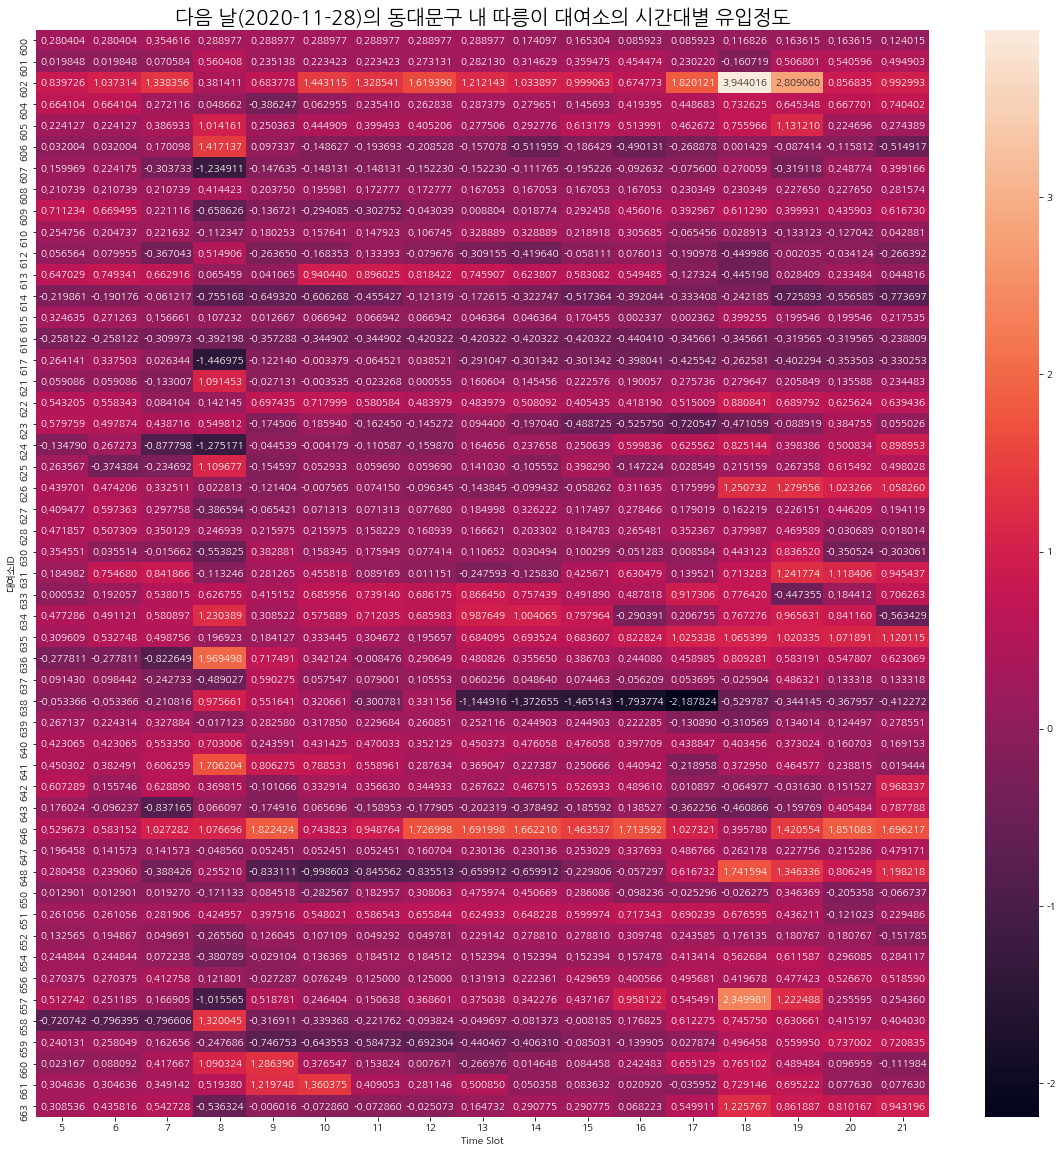

In [41]:
plt.figure(figsize=(20,20))
sns.heatmap(Bike_Map, annot=True, fmt=".6f")
plt.title('다음 날(' + str(tomorrow) +')의 동대문구 내 따릉이 대여소의 시간대별 유입정도', fontsize=20)
plt.show()

### 2-6. 201126 예측값으로 해보기

In [45]:
param2 = [11, 0, 3.0, 10.0, 0.0, 1.7, 67.5, 0, 0, 0, 1, 0, 0, 0]
params2 = []
for i in time_slot:
    tmpp = param2.copy()
    tmpp[1] = i
    params2.append(tmpp)
    
params2 = np.array(params2)
#params2
input_params2 = pd.DataFrame(params2, columns = features)

In [46]:
Result_All2 = {}
for stop_id in Bike_Stop_ID:
    Result_All2[str(stop_id)] = {}
    for time in time_slot:
        inflow = Model_Inflow[str(stop_id)].predict(input_params2)
        outflow = Model_Outflow[str(stop_id)].predict(input_params2)
        delta = alpha * (inflow - outflow) + (1 - alpha) * inflow
        Result_All2[str(stop_id)]['대여소ID'] = stop_id
        Result_All2[str(stop_id)]['Time Slot'] = time_slot
        Result_All2[str(stop_id)]['Inflow'] = inflow
        Result_All2[str(stop_id)]['Outflow'] = outflow
        Result_All2[str(stop_id)]['Delta'] = delta

In [47]:
Result2 = pd.DataFrame(Result_All2['600'])
for id_stop in Bike_Stop_ID:
    if id_stop == 600:
        continue
    tmppp = pd.DataFrame(Result_All2[str(id_stop)])
    Result2 = pd.concat([Result2, tmppp])
    
Result2 = Result2.reset_index(drop = True)
Result2

,대여소ID,Time Slot,Inflow,Outflow,Delta
0,600,5,1.143319,1.337173,0.006723
1,600,6,1.143319,1.337173,0.006723
2,600,7,1.226451,1.337173,0.089854
3,600,8,1.226451,1.414396,0.024215
4,600,9,1.226451,1.414396,0.024215
...,...,...,...,...,...
862,663,17,2.535761,2.952500,0.026136
863,663,18,3.017593,3.073582,0.405048
864,663,19,2.642195,3.032130,0.064885
865,663,20,3.175183,2.534794,1.020608


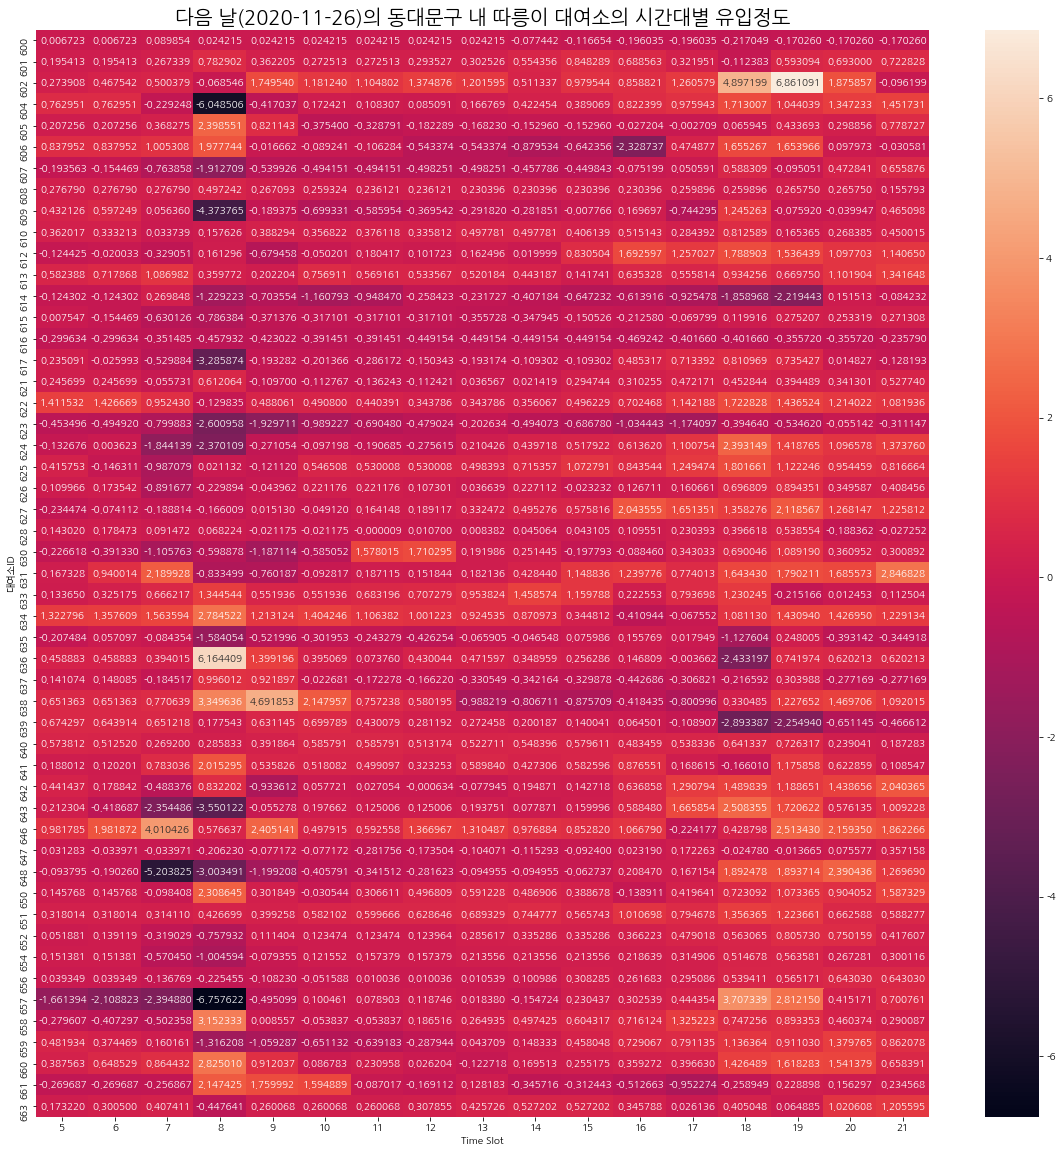

In [48]:
Bike_Map2 = Result2.pivot('대여소ID', 'Time Slot', 'Delta')
plt.figure(figsize=(20,20))
sns.heatmap(Bike_Map2, annot=True, fmt=".6f")
plt.title('다음 날(2020-11-26)의 동대문구 내 따릉이 대여소의 시간대별 유입정도', fontsize=20)
plt.show()

## 3. 경로 추천
- 51개 대여소
- 2개의 방역 팀
- 평균 이동시간: 대략 15분
- 대여소별 소독 시간: 15분이라고 가정
- ==> 즉, 한 시간마다 2군데씩 가능

### 대여소 배분
- 팀 A: 25개 + 7개(TOP 13) = 32개 (6~22시 동안 한 시간마다 2군데씩 소독 가능)
- 팀 B: 26개 + 6개(TOP 13) = 32개 (6~22시 동안 한 시간마다 2군데씩 소독 가능)

> - 이용률 많은 대여소 TOP 13: 5 ~ 21시 모두 더한 값이 가장 큰 순서대로
> - 사실상 소독 시간은 6 ~ 22시
    > - 5시의 수치대로 6시에 소독하는 형태 (1시간 밀려서)
    
### 사용할 자료형
- 각 대여소마다 유입정도 큰 순서로 (time: 5~20시)
    - ['600'] = {('9', '3.XXXX'), ('10', '1.XXXX'), .... }
    - ['663'] = { ... }
- 각 대여소마다 5~21시 수치 모두 더한 값 내림차순으로 정렬해서 TOP 13 저장
- 각 대여소마다 방문한 횟수 체크
    - {'600': 1, '601': 0, '602': 2, ... }
- 시간대별 그 시간대가 제일 유입정도 큰 대여소ID
    - 2차원 list?
    - 5시 = [0] ['600', '613', ..] 이런식으로
- 팀 A, 팀 B 경로
    - A = {'6': ('[id]', '[유입정도]'), ... '21': (,)}
    - or A = {'6': ('경도', '위도'), ... '21': ('경도', '위도')}

### 3-1. TOP 13

In [155]:
top_13 = []
for stop_id in Bike_Stop_ID:
    sum = 0
    for delta in Result_All2[str(stop_id)]['Delta']:
        sum += delta
    top_13.append((str(stop_id),str(sum)))
    
top_13_sorted = sorted(top_13, key=lambda tup: float(tup[1]), reverse = True)
top_13_sorted = top_13_sorted[0:13]
top_13_sorted

[('602', '24.93356555700302'),
 ('646', '23.359947830438614'),
 ('634', '18.583473652601242'),
 ('622', '13.919882416725159'),
 ('638', '13.830032587051392'),
 ('631', '13.688968285918236'),
 ('660', '12.283927664160728'),
 ('651', '11.222624331712723'),
 ('613', '11.152664572000504'),
 ('627', '10.72513696551323'),
 ('633', '10.692405551671982'),
 ('636', '10.543453097343445'),
 ('625', '9.863486349582672')]

### 3-2. 몇 번 다녀갔는지 저장 (0으로 초기화) ==> 3-5에서 다시

In [61]:
visit_count = {}
for stop_id in Bike_Stop_ID:
    visit_count[str(stop_id)] = 0
visit_count

{'600': 0,
 '601': 0,
 '602': 0,
 '604': 0,
 '605': 0,
 '606': 0,
 '607': 0,
 '608': 0,
 '609': 0,
 '610': 0,
 '612': 0,
 '613': 0,
 '614': 0,
 '615': 0,
 '616': 0,
 '617': 0,
 '621': 0,
 '622': 0,
 '623': 0,
 '624': 0,
 '625': 0,
 '626': 0,
 '627': 0,
 '628': 0,
 '630': 0,
 '631': 0,
 '633': 0,
 '634': 0,
 '635': 0,
 '636': 0,
 '637': 0,
 '638': 0,
 '639': 0,
 '640': 0,
 '641': 0,
 '642': 0,
 '643': 0,
 '646': 0,
 '647': 0,
 '648': 0,
 '650': 0,
 '651': 0,
 '652': 0,
 '654': 0,
 '656': 0,
 '657': 0,
 '658': 0,
 '659': 0,
 '660': 0,
 '661': 0,
 '663': 0}

### 3-3. 각 대여소마다 유입정도 큰 순서로 (time slot: 5~20)

In [77]:
desired_order = {}
for stop_id in Bike_Stop_ID:
    desired_order[str(stop_id)] = []
    # 해당 대여소에서 delta가 큰 순서로 (시간, delta) 저장
    delta = Result_All2[str(stop_id)]['Delta'].copy()
    
    delta_t = []
    for d, t in zip(delta, range(5, 22)):
        delta_t.append((str(t), d))
    delta_t = delta_t[0:16]
    
    delta_t_sorted = sorted(delta_t, key=lambda tup: float(tup[1]), reverse = True)
    desired_order[str(stop_id)] = delta_t_sorted
desired_order

{'600': [('7', 0.0898543),
  ('8', 0.024214685),
  ('9', 0.024214685),
  ('10', 0.024214685),
  ('11', 0.024214685),
  ('12', 0.024214685),
  ('13', 0.024214685),
  ('5', 0.0067227334),
  ('6', 0.0067227334),
  ('14', -0.07744196),
  ('15', -0.116654456),
  ('19', -0.17026041),
  ('20', -0.17026041),
  ('16', -0.19603515),
  ('17', -0.19603515),
  ('18', -0.21704887)],
 '601': [('15', 0.848289),
  ('8', 0.7829016),
  ('20', 0.6930001),
  ('16', 0.6885632),
  ('19', 0.59309405),
  ('14', 0.5543562),
  ('9', 0.36220503),
  ('17', 0.3219508),
  ('13', 0.30252552),
  ('12', 0.2935267),
  ('10', 0.27251324),
  ('11', 0.27251324),
  ('7', 0.26733947),
  ('5', 0.19541304),
  ('6', 0.19541304),
  ('18', -0.11238259)],
 '602': [('19', 6.861091),
  ('18', 4.8971987),
  ('20', 1.8758566),
  ('9', 1.7495401),
  ('12', 1.374876),
  ('17', 1.2605791),
  ('13', 1.2015951),
  ('10', 1.1812404),
  ('11', 1.1048023),
  ('15', 0.97954446),
  ('16', 0.8588207),
  ('14', 0.5113369),
  ('7', 0.50037897),
  

### 3-4. 시간대별 그 시간대가 제일 유입정도가 큰 대여소ID

In [89]:
largest_stop = {}
temp = []
for stop_id in Bike_Stop_ID:
    temp.append(tuple(list([str(stop_id)]) + list(desired_order[str(stop_id)][0])))
#temp
for t in range(5, 21):
    largest_stop[str(t)] = []
    for tup in temp:
        if t == int(tup[1]):
            largest_stop[str(t)].append((tup[0], tup[2]))
    largest_stop[str(t)] = sorted(largest_stop[str(t)], key=lambda tup: float(tup[1]), reverse = True)
    
largest_stop
    

{'5': [('616', -0.2996341)],
 '6': [],
 '7': [('646', 4.0104256),
  ('631', 2.189928),
  ('614', 0.26984817),
  ('600', 0.0898543)],
 '8': [('636', 6.164409),
  ('658', 3.1523325),
  ('660', 2.8250096),
  ('634', 2.784522),
  ('605', 2.3985515),
  ('650', 2.3086452),
  ('661', 2.1474252),
  ('641', 2.015295),
  ('606', 1.9777441),
  ('637', 0.99601245),
  ('621', 0.61206436),
  ('608', 0.4972418)],
 '9': [('638', 4.6918526)],
 '10': [('639', 0.6997892)],
 '11': [],
 '12': [('630', 1.7102946)],
 '13': [],
 '14': [('633', 1.458574)],
 '15': [('601', 0.848289)],
 '16': [],
 '17': [('647', 0.17226335)],
 '18': [('657', 3.7073386),
  ('643', 2.5083554),
  ('624', 2.3931494),
  ('625', 1.801661),
  ('612', 1.7889028),
  ('622', 1.7228276),
  ('604', 1.7130069),
  ('642', 1.4898388),
  ('651', 1.3563654),
  ('609', 1.245263),
  ('610', 0.81258893),
  ('617', 0.810969),
  ('607', 0.58830917)],
 '19': [('602', 6.861091),
  ('627', 2.1185668),
  ('626', 0.8943509),
  ('652', 0.80573016),
  ('640

### 3-5. 배정 순서 (w/ 대여소별 방문 횟수 카운팅)
1. 전 시간대에 제일 유입이 활발했던 대여소들 (최대 4개)
2. 제일 유입이 활발했던 대여소의 개수가 4개가 넘는 시간대의 경우, 그 다음 시간대로 가득 채워가며 넘김
3. 대여소별 방문 횟수가 0인 대여소 + TOP 13 대여소는 남는 시간대에 무작위로 방문

In [265]:
visit_count = {}
for stop_id in Bike_Stop_ID:
    visit_count[str(stop_id)] = 0
#visit_count

In [266]:
visit_order = {}
remainder = []
for t in range(6, 22):
    visit_order[str(t)] = []
    if len(largest_stop[str(t-1)]) <= 4:
        for idx, val in largest_stop[str(t-1)]:
            visit_order[str(t)].append(idx)
            visit_count[idx] += 1
    else: # if len(largest_stop[str(t-1)]) > 4:
        i = 0
        for idx, val in largest_stop[str(t-1)]:
            if i == 4:
                break
            visit_order[str(t)].append(idx)
            visit_count[idx] += 1
            i += 1
        remainder += largest_stop[str(t-1)][4:]
    
    remainder = sorted(remainder, key=lambda tup: tup[1], reverse = True)
    print(remainder)
    
    if len(visit_order[str(t)]) < 4 and len(remainder) != 0 :
        i = 0
        for i in range(4-len(visit_order[str(t)])):
            if len(remainder) == 0:
                break
            idx = int(remainder.pop(0)[0])
            visit_order[str(t)].append(str(idx))
            visit_count[str(idx)] += 1
        '''
        for idx, val in remainder:
            if i == 4-len(visit_order[str(t)]):
                break
            visit_order[str(t)].append(idx)
            visit_count[idx] += 1
            del remainder[0]
            i += 1
        '''

[]
[]
[]
[('605', 2.3985515), ('650', 2.3086452), ('661', 2.1474252), ('641', 2.015295), ('606', 1.9777441), ('637', 0.99601245), ('621', 0.61206436), ('608', 0.4972418)]
[('605', 2.3985515), ('650', 2.3086452), ('661', 2.1474252), ('641', 2.015295), ('606', 1.9777441), ('637', 0.99601245), ('621', 0.61206436), ('608', 0.4972418)]
[('641', 2.015295), ('606', 1.9777441), ('637', 0.99601245), ('621', 0.61206436), ('608', 0.4972418)]
[('621', 0.61206436), ('608', 0.4972418)]
[]
[]
[]
[]
[]
[]
[('612', 1.7889028), ('622', 1.7228276), ('604', 1.7130069), ('642', 1.4898388), ('651', 1.3563654), ('609', 1.245263), ('610', 0.81258893), ('617', 0.810969), ('607', 0.58830917)]
[('612', 1.7889028), ('622', 1.7228276), ('604', 1.7130069), ('642', 1.4898388), ('651', 1.3563654), ('609', 1.245263), ('610', 0.81258893), ('617', 0.810969), ('640', 0.7263168), ('607', 0.58830917), ('654', 0.5635807), ('628', 0.53855383), ('615', 0.2752074), ('635', 0.24800453)]
[('612', 1.7889028), ('622', 1.7228276), 

In [267]:
visit_order

{'6': ['616'],
 '7': [],
 '8': ['646', '631', '614', '600'],
 '9': ['636', '658', '660', '634'],
 '10': ['638', '605', '650', '661'],
 '11': ['639', '641', '606', '637'],
 '12': ['621', '608'],
 '13': ['630'],
 '14': [],
 '15': ['633'],
 '16': ['601'],
 '17': [],
 '18': ['647'],
 '19': ['657', '643', '624', '625'],
 '20': ['602', '627', '626', '652'],
 '21': ['648', '659', '613', '663']}

In [268]:
remainder

[('612', 1.7889028),
 ('622', 1.7228276),
 ('604', 1.7130069),
 ('642', 1.4898388),
 ('651', 1.3563654),
 ('609', 1.245263),
 ('610', 0.81258893),
 ('617', 0.810969),
 ('640', 0.7263168),
 ('656', 0.64303017),
 ('607', 0.58830917),
 ('654', 0.5635807),
 ('628', 0.53855383),
 ('615', 0.2752074),
 ('635', 0.24800453),
 ('623', -0.055142194)]

In [269]:
visit_count

{'600': 1,
 '601': 1,
 '602': 1,
 '604': 0,
 '605': 1,
 '606': 1,
 '607': 0,
 '608': 1,
 '609': 0,
 '610': 0,
 '612': 0,
 '613': 1,
 '614': 1,
 '615': 0,
 '616': 1,
 '617': 0,
 '621': 1,
 '622': 0,
 '623': 0,
 '624': 1,
 '625': 1,
 '626': 1,
 '627': 1,
 '628': 0,
 '630': 1,
 '631': 1,
 '633': 1,
 '634': 1,
 '635': 0,
 '636': 1,
 '637': 1,
 '638': 1,
 '639': 1,
 '640': 0,
 '641': 1,
 '642': 0,
 '643': 1,
 '646': 1,
 '647': 1,
 '648': 1,
 '650': 1,
 '651': 0,
 '652': 1,
 '654': 0,
 '656': 0,
 '657': 1,
 '658': 1,
 '659': 1,
 '660': 1,
 '661': 1,
 '663': 1}

In [270]:
remainder += top_13_sorted
remainder

[('612', 1.7889028),
 ('622', 1.7228276),
 ('604', 1.7130069),
 ('642', 1.4898388),
 ('651', 1.3563654),
 ('609', 1.245263),
 ('610', 0.81258893),
 ('617', 0.810969),
 ('640', 0.7263168),
 ('656', 0.64303017),
 ('607', 0.58830917),
 ('654', 0.5635807),
 ('628', 0.53855383),
 ('615', 0.2752074),
 ('635', 0.24800453),
 ('623', -0.055142194),
 ('602', '24.93356555700302'),
 ('646', '23.359947830438614'),
 ('634', '18.583473652601242'),
 ('622', '13.919882416725159'),
 ('638', '13.830032587051392'),
 ('631', '13.688968285918236'),
 ('660', '12.283927664160728'),
 ('651', '11.222624331712723'),
 ('613', '11.152664572000504'),
 ('627', '10.72513696551323'),
 ('633', '10.692405551671982'),
 ('636', '10.543453097343445'),
 ('625', '9.863486349582672')]

In [271]:
# visit_order[id] len가 4보다 작은 경우, remainder에서 하나씩 빼서 넣어줌 & visit_count[id]++
for t in range(6, 22):
    if len(visit_order[str(t)]) >= 4:
        continue
    # if len(visit_order[str(t)])< 4:
    i = 0
    for i in range(4-len(visit_order[str(t)])):
        if len(remainder) == 0:
            break
        idx = int(remainder.pop(0)[0])
        visit_order[str(t)].append(str(idx))
        visit_count[str(idx)] += 1

In [272]:
visit_order

{'6': ['616', '612', '622', '604'],
 '7': ['642', '651', '609', '610'],
 '8': ['646', '631', '614', '600'],
 '9': ['636', '658', '660', '634'],
 '10': ['638', '605', '650', '661'],
 '11': ['639', '641', '606', '637'],
 '12': ['621', '608', '617', '640'],
 '13': ['630', '656', '607', '654'],
 '14': ['628', '615', '635', '623'],
 '15': ['633', '602', '646', '634'],
 '16': ['601', '622', '638', '631'],
 '17': ['660', '651', '613', '627'],
 '18': ['647', '633', '636', '625'],
 '19': ['657', '643', '624', '625'],
 '20': ['602', '627', '626', '652'],
 '21': ['648', '659', '613', '663']}

In [273]:
visit_count

{'600': 1,
 '601': 1,
 '602': 2,
 '604': 1,
 '605': 1,
 '606': 1,
 '607': 1,
 '608': 1,
 '609': 1,
 '610': 1,
 '612': 1,
 '613': 2,
 '614': 1,
 '615': 1,
 '616': 1,
 '617': 1,
 '621': 1,
 '622': 2,
 '623': 1,
 '624': 1,
 '625': 2,
 '626': 1,
 '627': 2,
 '628': 1,
 '630': 1,
 '631': 2,
 '633': 2,
 '634': 2,
 '635': 1,
 '636': 2,
 '637': 1,
 '638': 2,
 '639': 1,
 '640': 1,
 '641': 1,
 '642': 1,
 '643': 1,
 '646': 2,
 '647': 1,
 '648': 1,
 '650': 1,
 '651': 2,
 '652': 1,
 '654': 1,
 '656': 1,
 '657': 1,
 '658': 1,
 '659': 1,
 '660': 2,
 '661': 1,
 '663': 1}

In [274]:
# team_A와 team_B에게 배분
team_A = {}
team_B = {}

for t in range(6, 22):
    team_A[str(t)] = []
    team_B[str(t)] = []
    team_A[str(t)].append(visit_order[str(t)][0])
    team_A[str(t)].append(visit_order[str(t)][2])
    team_B[str(t)].append(visit_order[str(t)][1])
    team_B[str(t)].append(visit_order[str(t)][3])

print(team_A)
print(team_B)

{'6': ['616', '622'], '7': ['642', '609'], '8': ['646', '614'], '9': ['636', '660'], '10': ['638', '650'], '11': ['639', '606'], '12': ['621', '617'], '13': ['630', '607'], '14': ['628', '635'], '15': ['633', '646'], '16': ['601', '638'], '17': ['660', '613'], '18': ['647', '636'], '19': ['657', '624'], '20': ['602', '626'], '21': ['648', '613']}
{'6': ['612', '604'], '7': ['651', '610'], '8': ['631', '600'], '9': ['658', '634'], '10': ['605', '661'], '11': ['641', '637'], '12': ['608', '640'], '13': ['656', '654'], '14': ['615', '623'], '15': ['602', '634'], '16': ['622', '631'], '17': ['651', '627'], '18': ['633', '625'], '19': ['643', '625'], '20': ['627', '652'], '21': ['659', '663']}


## 4. 효용성 검증

### 4-1. 대여소별 거치대수 불러오기

In [200]:
Bike_Stop = pd.read_excel('./raw data/대여소/서울특별시 공공자전거 대여소 정보(19.12.9).xlsx')

bike_num = []
dong = Bike_Stop[Bike_Stop['대여소ID'].isin(Bike_Stop_ID)].reset_index(drop=True).copy()

for i, idx in zip(range(len(dong)), Bike_Stop_ID): 
    bike_num.append((str(idx), dong.loc[i, "거치대수"]))

bike_num

[('600', 10),
 ('601', 10),
 ('602', 10),
 ('604', 15),
 ('605', 8),
 ('606', 15),
 ('607', 10),
 ('608', 10),
 ('609', 20),
 ('610', 10),
 ('612', 20),
 ('613', 10),
 ('614', 20),
 ('615', 20),
 ('616', 20),
 ('617', 20),
 ('621', 13),
 ('622', 15),
 ('623', 20),
 ('624', 10),
 ('625', 9),
 ('626', 10),
 ('627', 10),
 ('628', 15),
 ('630', 15),
 ('631', 15),
 ('633', 8),
 ('634', 20),
 ('635', 12),
 ('636', 9),
 ('637', 10),
 ('638', 20),
 ('639', 14),
 ('640', 6),
 ('641', 10),
 ('642', 7),
 ('643', 10),
 ('646', 10),
 ('647', 10),
 ('648', 15),
 ('650', 20),
 ('651', 10),
 ('652', 20),
 ('654', 10),
 ('656', 10),
 ('657', 13),
 ('658', 10),
 ('659', 15),
 ('660', 10),
 ('661', 10),
 ('663', 10)]

### 4-2. 예상 유효 소독 대수를 구함

In [302]:
# visit_order 이용해서, Result_All2
disinfected = {}
for stop_id, i in zip(Bike_Stop_ID, range(51)):
    #disinfected[str(stop_id)] = 0
    t = 0
    for t in range(6, 22):
        if str(stop_id) in visit_order[str(t)]:
            break
    disinfected_sum = float(bike_num[i][1])
    for l in range(t-5):
        disinfected_sum = disinfected_sum + Result_All2[str(stop_id)]['Inflow'][l] - Result_All2[str(stop_id)]['Outflow'][l]
        print(stop_id, t, l)
    disinfected[str(stop_id)] = disinfected_sum
'''
for stop_id, i in zip(Bike_Stop_ID, range(51)):
    if visit_count[str(stop_id)] == 2:
        disinfected[str(stop_id)] = disinfected[str(stop_id)] - bike_num[i][1]
'''


600 8 0
600 8 1
600 8 2
601 16 0
601 16 1
601 16 2
601 16 3
601 16 4
601 16 5
601 16 6
601 16 7
601 16 8
601 16 9
601 16 10
602 15 0
602 15 1
602 15 2
602 15 3
602 15 4
602 15 5
602 15 6
602 15 7
602 15 8
602 15 9
604 6 0
605 10 0
605 10 1
605 10 2
605 10 3
605 10 4
606 11 0
606 11 1
606 11 2
606 11 3
606 11 4
606 11 5
607 13 0
607 13 1
607 13 2
607 13 3
607 13 4
607 13 5
607 13 6
607 13 7
608 12 0
608 12 1
608 12 2
608 12 3
608 12 4
608 12 5
608 12 6
609 7 0
609 7 1
610 7 0
610 7 1
612 6 0
613 17 0
613 17 1
613 17 2
613 17 3
613 17 4
613 17 5
613 17 6
613 17 7
613 17 8
613 17 9
613 17 10
613 17 11
614 8 0
614 8 1
614 8 2
615 14 0
615 14 1
615 14 2
615 14 3
615 14 4
615 14 5
615 14 6
615 14 7
615 14 8
616 6 0
617 12 0
617 12 1
617 12 2
617 12 3
617 12 4
617 12 5
617 12 6
621 12 0
621 12 1
621 12 2
621 12 3
621 12 4
621 12 5
621 12 6
622 6 0
623 14 0
623 14 1
623 14 2
623 14 3
623 14 4
623 14 5
623 14 6
623 14 7
623 14 8
624 19 0
624 19 1
624 19 2
624 19 3
624 19 4
624 19 5
624 19 6
624

'\nfor stop_id, i in zip(Bike_Stop_ID, range(51)):\n    if visit_count[str(stop_id)] == 2:\n        disinfected[str(stop_id)] = disinfected[str(stop_id)] - bike_num[i][1]\n'

In [303]:
disinfected

{'600': 9.501572132110596,
 '601': 11.97648537158966,
 '602': 14.573842644691467,
 '604': 15.677203297615051,
 '605': 10.627004742622375,
 '606': 17.893163681030273,
 '607': 2.4765498638153076,
 '608': 10.951363444328308,
 '609': 20.577348232269287,
 '610': 10.342792987823486,
 '612': 19.649280667304993,
 '613': 12.473911881446838,
 '614': 19.038236618041992,
 '615': 14.645529866218567,
 '616': 19.462515234947205,
 '617': 13.456663131713867,
 '621': 11.999801278114319,
 '622': 16.188337326049805,
 '623': 6.934521794319153,
 '624': 4.913048624992371,
 '625': 9.957714796066284,
 '626': 6.766046404838562,
 '627': 10.281416594982147,
 '628': 13.680366039276123,
 '630': 11.119335174560547,
 '631': 17.326705813407898,
 '633': 12.241404056549072,
 '634': 26.230257391929626,
 '635': 5.807832300662994,
 '636': 15.577563166618347,
 '637': 10.326858401298523,
 '638': 29.36739408969879,
 '639': 16.29877734184265,
 '640': 7.542926907539368,
 '641': 12.467167139053345,
 '642': 7.262698948383331,
 '6

In [287]:
disinfected_day = 0
for stop_id in Bike_Stop_ID:
    print(disinfected[str(stop_id)])
    if disinfected[str(stop_id)] > 0:
        disinfected_day += disinfected[str(stop_id)]
print("하루 동안의 총 예상 소독 대수: ", disinfected_day)

9.501572132110596
11.97648537158966
14.573842644691467
15.677203297615051
10.627004742622375
17.893163681030273
2.4765498638153076
10.951363444328308
20.577348232269287
10.342792987823486
19.649280667304993
12.473911881446838
19.038236618041992
14.645529866218567
19.462515234947205
13.456663131713867
11.999801278114319
16.188337326049805
6.934521794319153
4.913048624992371
9.957714796066284
6.766046404838562
10.281416594982147
13.680366039276123
11.119335174560547
17.326705813407898
12.241404056549072
26.230257391929626
5.807832300662994
15.577563166618347
10.326858401298523
29.36739408969879
16.29877734184265
7.542926907539368
12.467167139053345
7.262698948383331
4.531955003738403
15.831297159194946
6.1972304582595825
3.547556459903717
20.990203857421875
10.307867288589478
20.157401204109192
7.1240071058273315
7.721617817878723
-1.0023963451385498
10.669779896736145
11.172045350074768
13.93521773815155
12.003985404968262
9.482716083526611
하루 동안의 총 예상 소독 대수:  629.2865182161331


In [278]:
bike_num_sum = 0
for i in range(len(Bike_Stop_ID)):
    #print(bike_num[i][1])
    bike_num_sum += bike_num[i][1]
print("전체 대여소의 총 대수: ", bike_num_sum)

전체 대여소의 총 대수:  659


### 4-3. 랜덤 경로

In [279]:
#import random
random_order = list(Bike_Stop_ID.copy().astype(str))
#random_order

In [280]:
for i, num in top_13_sorted:
    random_order.append(i)
#random_order

In [281]:
len(random_order)

64

In [282]:
random.shuffle(random_order)
random_order

['638',
 '659',
 '634',
 '652',
 '613',
 '660',
 '633',
 '642',
 '631',
 '641',
 '663',
 '630',
 '635',
 '651',
 '609',
 '656',
 '622',
 '636',
 '627',
 '604',
 '637',
 '621',
 '657',
 '640',
 '634',
 '660',
 '633',
 '601',
 '648',
 '628',
 '646',
 '624',
 '608',
 '607',
 '626',
 '658',
 '639',
 '643',
 '646',
 '651',
 '622',
 '623',
 '638',
 '650',
 '631',
 '605',
 '625',
 '661',
 '610',
 '627',
 '600',
 '612',
 '647',
 '614',
 '625',
 '602',
 '606',
 '617',
 '654',
 '636',
 '602',
 '615',
 '616',
 '613']

In [283]:
visit_order_ran1 = {}

for t, i in zip(range(6, 22), range(0, 64, 4)):
    visit_order_ran1[str(t)] = random_order[i:i+4]
    
visit_order_ran1

{'6': ['638', '659', '634', '652'],
 '7': ['613', '660', '633', '642'],
 '8': ['631', '641', '663', '630'],
 '9': ['635', '651', '609', '656'],
 '10': ['622', '636', '627', '604'],
 '11': ['637', '621', '657', '640'],
 '12': ['634', '660', '633', '601'],
 '13': ['648', '628', '646', '624'],
 '14': ['608', '607', '626', '658'],
 '15': ['639', '643', '646', '651'],
 '16': ['622', '623', '638', '650'],
 '17': ['631', '605', '625', '661'],
 '18': ['610', '627', '600', '612'],
 '19': ['647', '614', '625', '602'],
 '20': ['606', '617', '654', '636'],
 '21': ['602', '615', '616', '613']}

In [262]:
list(range(0, 64, 4))

[0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60]

In [284]:
disinfected_ran1 = {}
for stop_id, i in zip(Bike_Stop_ID, range(51)):
    t = 0
    for t in range(6, 22):
        if str(stop_id) in visit_order_ran1[str(t)]:
            break
    disinfected_sum_ran1 = float(bike_num[i][1])
    for l in range(t-5):
        disinfected_sum_ran1 = disinfected_sum_ran1 + Result_All2[str(stop_id)]['Inflow'][l] - Result_All2[str(stop_id)]['Outflow'][l]
        print(stop_id, t, l)
    disinfected_ran1[str(stop_id)] = disinfected_sum_ran1

600 18 0
600 18 1
600 18 2
600 18 3
600 18 4
600 18 5
600 18 6
600 18 7
600 18 8
600 18 9
600 18 10
600 18 11
600 18 12
601 12 0
601 12 1
601 12 2
601 12 3
601 12 4
601 12 5
601 12 6
602 19 0
602 19 1
602 19 2
602 19 3
602 19 4
602 19 5
602 19 6
602 19 7
602 19 8
602 19 9
602 19 10
602 19 11
602 19 12
602 19 13
604 10 0
604 10 1
604 10 2
604 10 3
604 10 4
605 17 0
605 17 1
605 17 2
605 17 3
605 17 4
605 17 5
605 17 6
605 17 7
605 17 8
605 17 9
605 17 10
605 17 11
606 20 0
606 20 1
606 20 2
606 20 3
606 20 4
606 20 5
606 20 6
606 20 7
606 20 8
606 20 9
606 20 10
606 20 11
606 20 12
606 20 13
606 20 14
607 14 0
607 14 1
607 14 2
607 14 3
607 14 4
607 14 5
607 14 6
607 14 7
607 14 8
608 14 0
608 14 1
608 14 2
608 14 3
608 14 4
608 14 5
608 14 6
608 14 7
608 14 8
609 9 0
609 9 1
609 9 2
609 9 3
610 18 0
610 18 1
610 18 2
610 18 3
610 18 4
610 18 5
610 18 6
610 18 7
610 18 8
610 18 9
610 18 10
610 18 11
610 18 12
612 18 0
612 18 1
612 18 2
612 18 3
612 18 4
612 18 5
612 18 6
612 18 7
612 18

In [288]:
disinfected_day_ran1 = 0
for stop_id in Bike_Stop_ID:
    print(disinfected_ran1[str(stop_id)])
    if disinfected_ran1[str(stop_id)] > 0:
        disinfected_day_ran1 += disinfected_ran1[str(stop_id)]
print("하루 동안의 총 예상 소독 대수: ", disinfected_day_ran1)

6.809232473373413
10.901333689689636
20.629737496376038
7.817025542259216
6.261259198188782
13.229977369308472
1.6780482530593872
11.077481627464294
14.753482818603516
11.784599423408508
18.419065237045288
10.959870338439941
3.563823699951172
12.617666244506836
9.373050451278687
13.229344248771667
12.358564853668213
17.76642632484436
4.746535897254944
1.6077114343643188
9.074017524719238
6.788799524307251
8.104928076267242
13.868350863456726
12.290252685546875
17.326705813407898
8.030348420143127
21.161452412605286
9.00384670495987
16.728320002555847
10.326858401298523
20.509523630142212
16.447528958320618
7.192663192749023
10.399165749549866
7.262698948383331
0.8518853187561035
17.6376051902771
5.907866716384888
0.5391244292259216
20.95111632347107
10.65465497970581
19.88608682155609
7.713221311569214
8.779389381408691
-3.8703181743621826
9.728860855102539
15.297539591789246
10.67080307006836
9.449995279312134
10.237589240074158
하루 동안의 총 예상 소독 대수:  552.405436038971


### === 연습용 ===

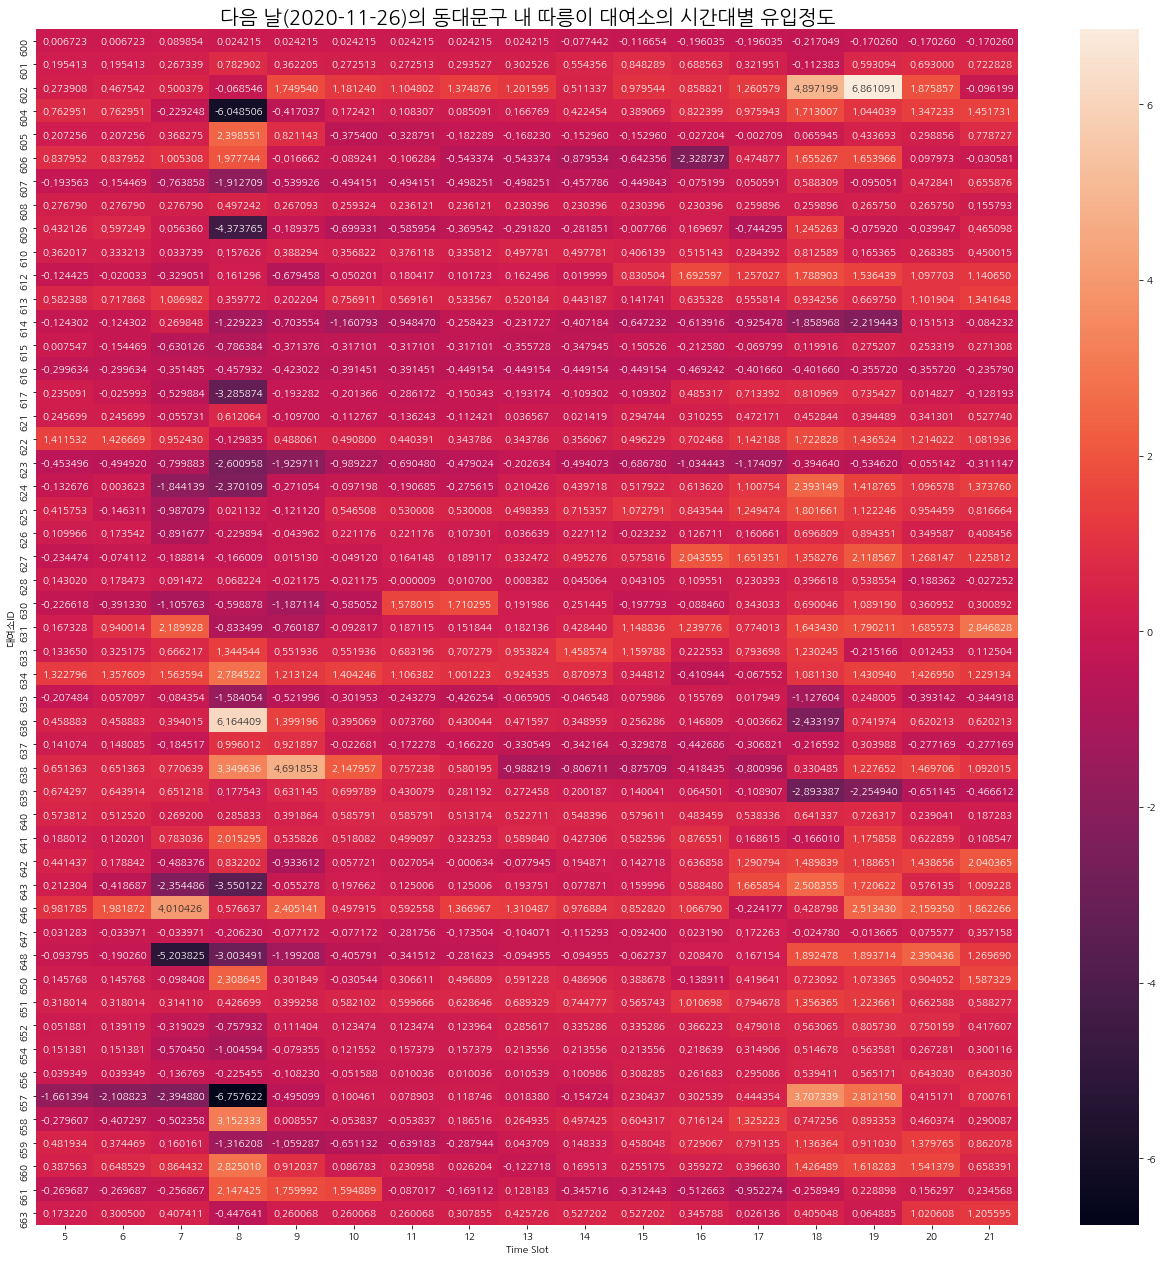

In [293]:
plt.figure(figsize=(22,22))
hm = sns.heatmap(Bike_Map2, annot=True, fmt=".6f")
plt.title('다음 날(2020-11-26)의 동대문구 내 따릉이 대여소의 시간대별 유입정도', fontsize=20)
fig = hm.get_figure()
fig.savefig('heatmap.png')

In [294]:
bike_num

with open('./bike_stop_data/Bike_Stop_NUM.pickle','wb') as fw:
    pickle.dump(bike_num, fw)

In [295]:
with open('./bike_stop_data/Bike_Stop_NUM.pickle', 'rb') as fr:
    user_loaded = pickle.load(fr)
    
user_loaded

[('600', 10),
 ('601', 10),
 ('602', 10),
 ('604', 15),
 ('605', 8),
 ('606', 15),
 ('607', 10),
 ('608', 10),
 ('609', 20),
 ('610', 10),
 ('612', 20),
 ('613', 10),
 ('614', 20),
 ('615', 20),
 ('616', 20),
 ('617', 20),
 ('621', 13),
 ('622', 15),
 ('623', 20),
 ('624', 10),
 ('625', 9),
 ('626', 10),
 ('627', 10),
 ('628', 15),
 ('630', 15),
 ('631', 15),
 ('633', 8),
 ('634', 20),
 ('635', 12),
 ('636', 9),
 ('637', 10),
 ('638', 20),
 ('639', 14),
 ('640', 6),
 ('641', 10),
 ('642', 7),
 ('643', 10),
 ('646', 10),
 ('647', 10),
 ('648', 15),
 ('650', 20),
 ('651', 10),
 ('652', 20),
 ('654', 10),
 ('656', 10),
 ('657', 13),
 ('658', 10),
 ('659', 15),
 ('660', 10),
 ('661', 10),
 ('663', 10)]

In [299]:
float('-2')

-2.0